<a href="https://colab.research.google.com/github/shirleyzz/cap5610_machineleanrning/blob/master/HW4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import tensorflow as tf
import keras
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
import matplotlib.pyplot as plt

# load train and test data
(train_images_original, train_labels_original), (test_images_original, test_labels_original) = mnist.load_data()

# preprocess data
train_images = train_images_original.reshape((60000, 28 * 28))
train_images = train_images.astype('float32') / 255
test_images = test_images_original.reshape((10000, 28 * 28))
test_images = test_images.astype('float32') / 255

train_labels = to_categorical(train_labels_original, num_classes=10) 
test_labels = to_categorical(test_labels_original, num_classes=10)

# set up layers
model = keras.Sequential([
    keras.layers.Dense(10, input_dim=784, activation=tf.nn.softmax)
])

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
# compile the model
model.compile(optimizer=sgd, loss='categorical_crossentropy',metrics=['accuracy'])

# train the model
epochs = 20
history = model.fit(train_images, 
                      train_labels, 
                      epochs=epochs,  
                      validation_data=(test_images, test_labels))

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 3s 53us/step - loss: 0.4195 - acc: 0.8836 - val_loss: 0.3069 - val_acc: 0.9167
Epoch 2/20
60000/60000 [==============================] - 2s 42us/step - loss: 0.3139 - acc: 0.9114 - val_loss: 0.2952 - val_acc: 0.9182
Epoch 3/20
60000/60000 [==============================] - 3s 42us/step - loss: 0.2967 - acc: 0.9160 - val_loss: 0.2873 - val_acc: 0.9206
Epoch 4/20
60000/60000 [==============================] - 3s 42us/step - loss: 0.2872 - acc: 0.9196 - val_loss: 0.2787 - val_acc: 0.9210
Epoch 5/20
60000/60000 [==============================] - 2s 41us/step - loss: 0.2821 - acc: 0.9216 - val_loss: 0.2800 - val_acc: 0.9196
Epoch 6/20
60000/60000 [==============================] - 3s 42us/step - loss: 0.2774 - acc: 0.9223 - val_loss: 0.2726 - val_acc: 0.9233
Epoch 7/

In [0]:
history_dict = history.history
loss_values = history_dict['loss']
test_loss_values = history_dict['val_loss']
epochs_range = range(1, epochs + 1)

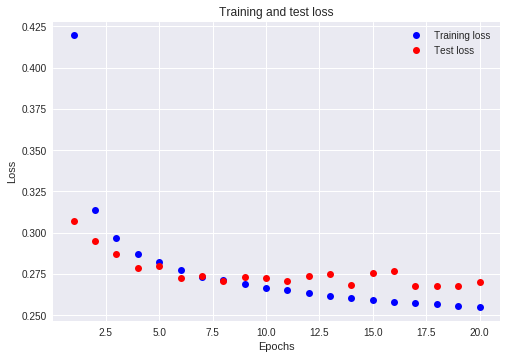

In [0]:
plt.plot(epochs_range, loss_values, 'bo', label='Training loss')
plt.plot(epochs_range, test_loss_values, 'ro', label='Test loss')
plt.title('Training and test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [0]:
acc_values = history_dict['acc']
test_acc_values = history_dict['val_acc']

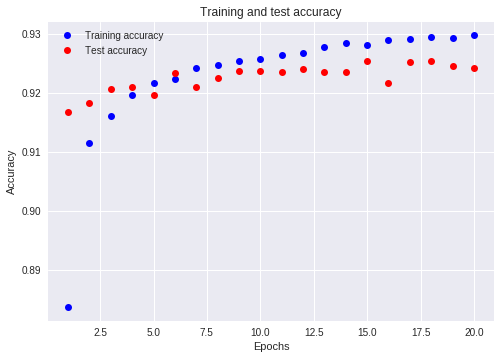

In [0]:
plt.plot(epochs_range, acc_values, 'bo', label='Training accuracy')
plt.plot(epochs_range, test_acc_values, 'ro', label='Test accuracy')
plt.title('Training and test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()